# Задание 2
- Шеверев Сергей Вячеславович
- 22М-05ММ
- Вариант 3

In [31]:
import numpy as np
np.random.seed(100)

import math 

from typing import Callable 
import functools
from matplotlib import pyplot as plt
from statistics import mode
import pandas as pd

def my_chisquare(f_obs, f_exp, size):
    res = 0.0
    for o, e in zip(f_obs, f_exp):
        res += ((o - e)**2)/e
    res *= size
    return 1 - stats.chi2.pdf(res, df = len(f_obs)-1), res

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## 1.Дискретные распределения 
Промоделируем сложно-пуассоновское распределение из прошлого задания (с внутренним отрицателным биномиальным):

Параметры распределений:
- Внутреннее:
 - **succ_number** - количесво успехов в испытаниях 
 - **succ_prob** - вероятность успеха
- Внешнее: 
 - **lam** - параметр $\lambda$
%- **amount_of_bins** - задает количество интервалов группировки при построении полигона частот
- **size** - параметр, управляющий размером выборки

In [3]:
succ_number = 5
succ_prob = 0.13
lam = 10
size = 10**6

amount_of_bins = 30

def complex_poisson(callee: Callable, lam: float = 1.0, size: int = 1000)->np.ndarray:
    res = np.random.poisson(lam, size)
    return np.array(list(map(sum, map(callee, res))))


def nbinom(size):
    return np.random.negative_binomial(n=succ_number, p=succ_prob, size=size)

def get_moment(data: np.array, mean = None, order: int =1):
    if mean is None:
        mean = data.mean()
    return sum((data - mean)**order)/len(data)


In [4]:
rv_realization = complex_poisson(nbinom, lam=lam, size=size)

Вычислим *рассеяние*:
$$ e = \frac{\sigma^2}{\mu} \text{, где } \mu = E\xi \text{, } \sigma^2 = D\xi$$

In [5]:
#rv_realization = np.random.negative_binomial(n=succ_number, p=succ_prob, size= size)

rv_expectation = rv_realization.mean()
rv_dispersion = math.pow(rv_realization.std(), 2)

rv_scattering = rv_dispersion/rv_expectation
print(f'Математическое ожидание: {rv_expectation}\nДисперсия: {rv_dispersion}\nРассение: {rv_scattering}')

Математическое ожидание: 334.500412
Дисперсия: 13755.532441830252
Рассение: 41.122617337255335


*Рассеяние* значительно больше 1 $\Rightarrow$ применяем модель отрицательно биномиального распределения.

#### Оценим параметры (Метод моментов)

 - $E\xi = \frac{kq}{p} \Rightarrow k = \frac{E\xi\cdot p}{q}$
 - $D\xi = \frac{kq}{p^2} \Rightarrow p = \frac{E\xi}{D\xi}$
 - $ k = \frac{E^2\xi}{D\xi - E\xi} $

In [6]:
rv_expectation2 = (rv_realization**2).mean()
k = rv_expectation2/(rv_dispersion - rv_expectation)
p = rv_expectation/rv_dispersion

In [7]:
print(f"Оценка параметров:\n\tВероятность успеха: {p}\n\tКоличество успехов: {k}")

Оценка параметров:
	Вероятность успеха: 0.024317518308690986
	Количество успехов: 9.361877521097695


In [8]:
import scipy.stats as stats

neg_binom = stats.nbinom(n=k, p=p)


counts, bins = np.histogram(rv_realization, bins=amount_of_bins)
counts = np.append(np.array(counts, dtype='float64')/size, 1 - sum(counts)/size)
counts = np.array(counts, dtype='float64')

counts2 = [ neg_binom.cdf(bins[i+1]) - neg_binom.cdf(bins[i]) for i in range(len(bins)-1)]
counts2.append(1 - sum(counts2))
counts2 = np.array(counts2, dtype='float64')


In [9]:
svalue, pvalue = stats.chisquare(f_obs=counts, f_exp=counts2)
print(f"Статистика хи-кватрат: {svalue}\npvalue: {pvalue}")

Статистика хи-кватрат: 0.7997622860853351
pvalue: 1.0


In [10]:
pvalue, svalue = my_chisquare(f_obs=counts, f_exp=counts2, size=size)
print(f"Статистика хи-кватрат: {svalue}\npvalue: {pvalue}")

Статистика хи-кватрат: 799762.2860853351
pvalue: 1.0


#### Оценка параметров (Метод максимального правдопобия)

In [11]:
from scipy import optimize
def func(x, rv_realization):
    res = 0.0
    for rv in rv_realization:
        res += np.log(stats.nbinom.pmf(k=rv, n=x[0], p=x[1]))
    return -res
    
res = optimize.minimize(func, [k, p], (rv_realization[:10000]), bounds=[(1, 2*k), (10**(-6), 0.5)])
print(res.x)

[7.85398296 0.02301856]


In [12]:
print(f'Оценка параметров:\n\tВероятнотсь успеха: {res.x[1]}\n\tКоличество успехов: {res.x[0]}')

Оценка параметров:
	Вероятнотсь успеха: 0.023018555864585535
	Количество успехов: 7.8539829578696665


In [13]:
neg_binom = stats.nbinom(n=int(res.x[0]), p=res.x[1])
counts3 = [ neg_binom.cdf(bins[i+1]) - neg_binom.cdf(bins[i]) for i in range(len(bins)-1)]
counts3.append(1 - sum(counts3))
counts3 = np.array(counts3, dtype='float64')

In [15]:
svalue, pvalue = stats.chisquare(f_obs=counts, f_exp=counts3)
print(f"Статистика хи-кватрат: {svalue}\npvalue: {pvalue}")

Статистика хи-кватрат: 0.1295730522779818
pvalue: 1.0


In [16]:
pvalue, svalue = my_chisquare(f_obs=counts, f_exp=counts3, size=size)
print(f"Статистика хи-кватрат: {svalue}\npvalue: {pvalue}")

Статистика хи-кватрат: 129573.05227798183
pvalue: 1.0


## 2.Абсолютно непрерывные распределения

Вариант - экспоненциальное распределение

In [17]:
lam = 1.5


expon = stats.expon(scale=1/lam)
rv_realization = expon.rvs( size=size, random_state=45)

In [18]:
counts, bins = np.histogram(rv_realization, bins=amount_of_bins)

counts = np.append(np.array(counts, dtype='float64')/size, 1 - sum(counts)/size)

#### Оценка параметров 

##### Метод моментов

$E\xi = \frac{1}{\lambda} \Rightarrow \lambda = \frac{1}{E\xi}$ 

In [19]:
lam1 = 1/rv_realization.mean()
print(f'Параметр lambda: {lam1}')

Параметр lambda: 1.4961684654360452


In [20]:

counts2 = [ stats.expon.cdf(bins[i+1], scale=1/lam1) - stats.expon.cdf(bins[i], scale=1/lam1) for i in range(len(bins)-1)]

counts2.append(1 - sum(counts2))
counts2 = np.array(counts2, dtype='float64')

In [21]:
svalue, pvalue = stats.chisquare(f_obs=counts, f_exp=counts2)
print(f"Статистика хи-кватрат: {svalue}\npvalue: {pvalue}")

Статистика хи-кватрат: 2.410208800533888e-05
pvalue: 1.0


In [22]:
pvalue, svalue = my_chisquare(f_obs=counts, f_exp=counts2, size=size)
print(f"Статистика хи-кватрат: {svalue}\npvalue: {pvalue}")

Статистика хи-кватрат: 24.10208800533888
pvalue: 0.954374761068423


##### Метод максимального правдоподобия

In [23]:
def func(x, rv_realization):
    res = 0.0
    for rv in rv_realization:
        res += np.log(stats.expon.pdf(x=rv, scale=1/x[0]))
    return -res
    
res = optimize.minimize(func, [lam1], (rv_realization[:10000]))
lam2 = res.x[0]
print(f'Параметр lambda: {lam2}')

Параметр lambda: 1.5089652591983855


In [24]:

counts3 = [ stats.expon.cdf(bins[i+1], scale=1/lam2) - stats.expon.cdf(bins[i], scale=1/lam2) for i in range(len(bins)-1)]

counts3.append(1 - sum(counts3))
counts3 = np.array(counts3, dtype='float64')

In [25]:
svalue, pvalue = stats.chisquare(f_obs=counts, f_exp=counts3)
print(f"Статистика хи-кватрат: {svalue}\npvalue: {pvalue}")

Статистика хи-кватрат: 0.00010018966853831829
pvalue: 1.0


In [32]:
pvalue, svalue = my_chisquare(f_obs=counts, f_exp=counts3, size=size)
print(f"Статистика хи-кватрат: {svalue}\npvalue: {pvalue}")

Статистика хи-кватрат: 100.18966853831829
pvalue: 0.9999999993694018


#### Гистограмма

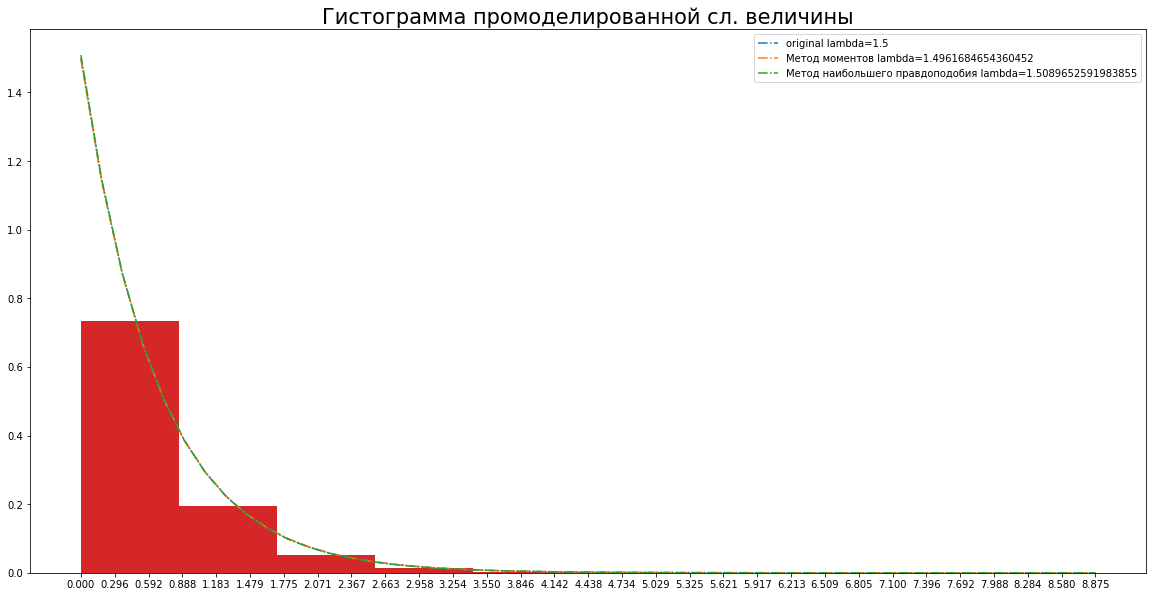

In [28]:
plt.figure().set_size_inches(20, 10)
plt.title('Гистограмма промоделированной сл. величины', fontsize=21)
space = np.linspace(bins[0], bins[-1])

plt.plot(space, [stats.expon.pdf(i, scale=1/lam) for i in space], '-.', label=f'original lambda={lam}')
plt.plot(space, [stats.expon.pdf(i, scale=1/lam1) for i in space], '-.', label=f'Метод моментов lambda={lam1}')
plt.plot(space, [stats.expon.pdf(i, scale=1/lam2) for i in space], '-.', label=f'Метод наибольшего правдоподобия lambda={lam2}')
plt.xticks(bins)
plt.hist(bins[:-1], weights=counts[:-1])
plt.legend()
plt.show()